<h1>Define headers</h1>

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import time
import statistics 
import math  

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D


from PIL import Image

import torch
torch.cuda.set_device(0)

<h1> Define Dataset</h1>

In [2]:
def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

<h1>Confirm if datasets works</h1>

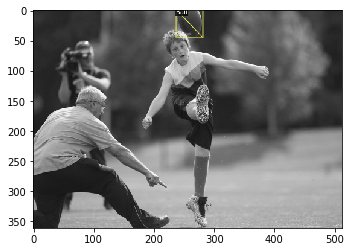

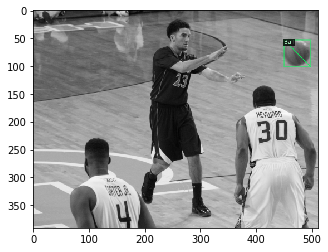

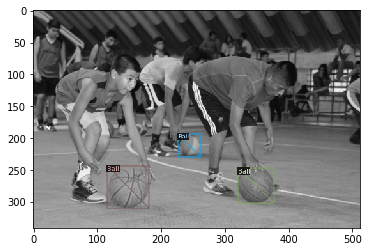

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/10 13:32:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[02/10 13:32:23 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[02/10 13:32:24 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[02/10 13:32:24 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/10 13:32:24 d2.data.build]: Using training sampler TrainingSampler
[02/10 13:32:24 d2.engine.train_loop]: Starting training from iteration 7000
[02/10 13:32:24 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


OrderedDict()

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

In [6]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
d_real=0.63 *1000#mm

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

cameraMatrix_IR=np.array([[705.1735, 0.000000, 172.6855],
                          [0.000000, 710.7784, 148.5702],
                          [0.000000, 0.000000, 1.000000]])
cameraMatrix_rgb_pointgrey=np.array([[1152.437560398629, 0, 478.3335229505631], 
                                    [0, 1155.693500473246, 351.508630859905], 
                                    [0, 0, 1]])

# 708.305362, 0.000000, 170.510788, 0.000000, 714.594222, 130.070494, 0.000000, 0.000000, 1.000000
cameraMatrix_IR=cameraMatrix_rgb_pointgrey

print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

[[1.15243756e+03 0.00000000e+00 4.78333523e+02]
 [0.00000000e+00 1.15569350e+03 3.51508631e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
1152.437560398629 1155.693500473246 478.3335229505631 351.508630859905


In [7]:
cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])


cameraMatrix_mono=np.array([[2363.738690444174,0,1072.79004424623],
[0,2370.592662770868, 788.4498446284557],
[0,0,1]])

cameraMatrix_RGB=cameraMatrix_mono

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

2363.738690444174 2370.592662770868 1072.79004424623 788.4498446284557


<h1> Plot 3D real points </h1>

974 3530


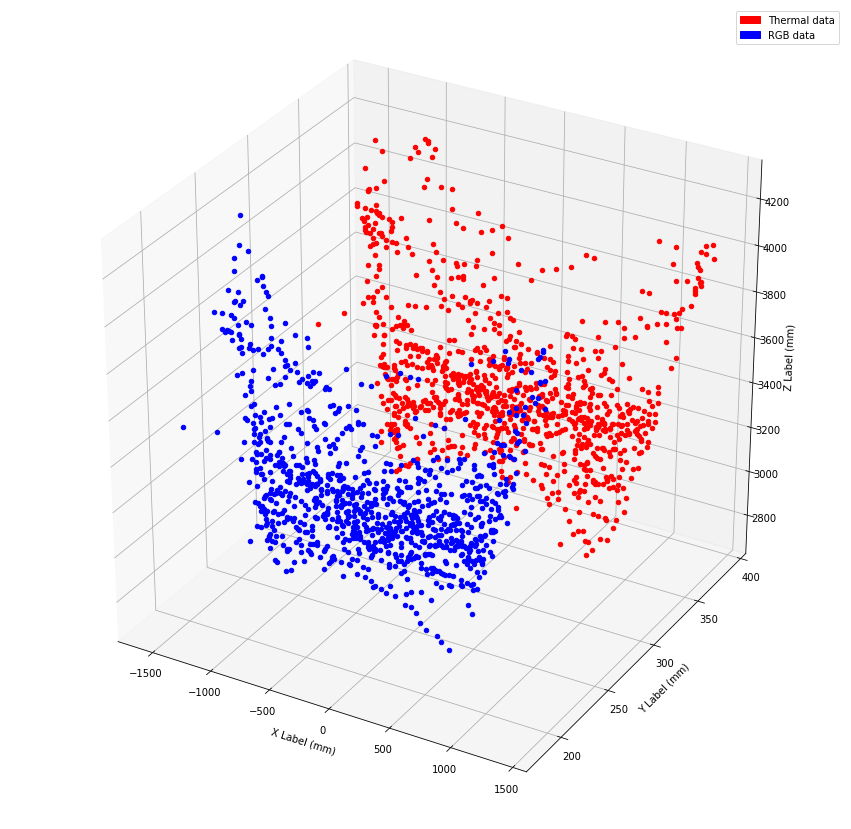

In [8]:
#read txt files with image path
txt_file_rgb =os.path.join("/home/danielarato/ball_detection/Datasets/train/3cameras/", "3cam_mono.txt")
f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/3cameras/", "3cam_RGB.txt")
f_ir = open(txt_file_ir, "r")

#iniciate 3d plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='blue', label='RGB data')
red_patch = mpatches.Patch(color='red', label='Thermal data')
plt.legend(handles=[red_patch,blue_patch])

ax.set_xlabel('X Label (mm)')
ax.set_ylabel('Y Label (mm)')
ax.set_zlabel('Z Label (mm)')


#initiate vectors
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
xpi=[]
ypi=[]
xpr=[]
ypr=[]
c=0
c_for=0

#for each figure in the path
for line_rgb in f_rgb: 
    c_for+=1
    # read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    if(line_ir==""):
        break
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")

    # CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 ):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

        if(cond1==False and cond2==False):
            #VISUAL
            xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
            X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
            Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb

            ax.scatter(X_rgb, Y_rgb, Z_rgb, c='b') #draw in plot
            #IR
            xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc=float("%0.2f"%xc)
            yc=float("%0.2f"%yc)

            dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix=(dx+dy)/2

            Z_ir=((fx+fy)/2)*(d_real/d_pix)
            X_ir=(Z_ir*(xc-cx))/fx
            Y_ir=(Z_ir*(yc-cy))/fy
            pix_ir=np.array([xc,yc,1])

            #append points
            Xr.append(X_rgb)
            Yr.append(Y_rgb)
            Zr.append(Z_rgb)
            Xt.append(X_ir)
            Yt.append(Y_ir)
            Zt.append(Z_ir) 
            xpr.append(xc_rgb)
            ypr.append(yc_rgb)
            xpi.append(xc)
            ypi.append(yc)

            ax.scatter(X_ir, Y_ir, Z_ir, c='r') #draw in plot
            
            c+=1
f_ir.close()        
f_rgb.close()
print(c,c_for)

In [9]:
cameraPoints_IR= cameraMatrix_IR.T @ (Z_ir*pix_ir)

print(X_ir, Y_ir, Z_ir)
print(pix_ir)

-1161.8153224460873 350.66140713641886 3908.301264175889
[135.75 455.2    1.  ]


<h1>Plot pixel points vs real distance to ball</h1>

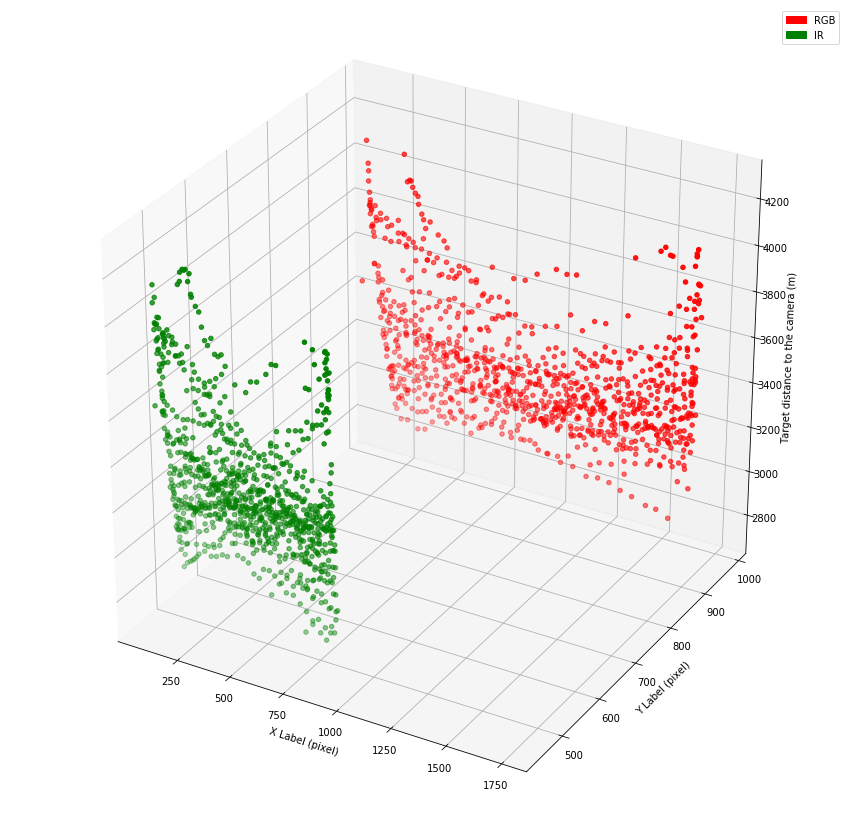

In [10]:
fig3 = plt.figure(figsize=(15,15))
ax3 = fig3.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch])
ax3.set_xlabel('X Label (pixel)')
ax3.set_ylabel('Y Label (pixel)')
ax3.set_zlabel('Target distance to the camera (m)')


ax3.scatter(xpr,ypr,Zr, c='r')
ax3.scatter(xpi,ypi,Zt, c='g')
# print(xpi)
# print(xpr)

<h1>Plot Ball Center in Pixels</h1>

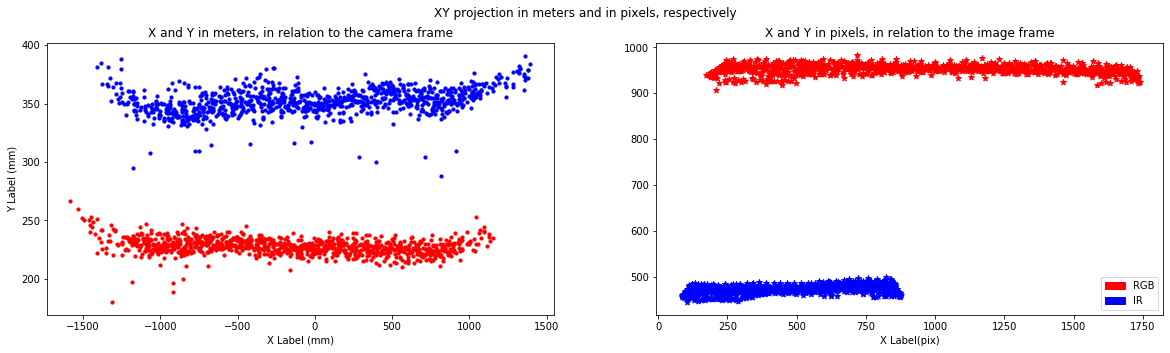

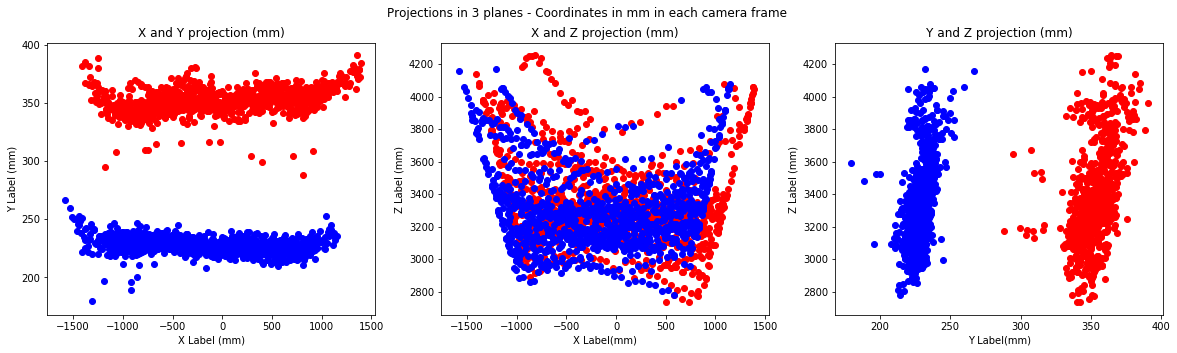

In [11]:
fig0, axs_0 = plt.subplots(1,2,figsize=(20,5))
blue_patch = mpatches.Patch(color='blue', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch])

fig0.suptitle("XY projection in meters and in pixels, respectively ")

axs_0[0].scatter(Xr,Yr,c='r',s=10)
axs_0[0].scatter(Xt,Yt,c='b',s=10)
axs_0[0].set_xlabel('X Label (mm)')
axs_0[0].set_ylabel('Y Label (mm)')
axs_0[0].set_title('X and Y in meters, in relation to the camera frame')

axs_0[1].scatter(xpr,ypr,c='r',marker="*")
axs_0[1].scatter(xpi,ypi,c='b',marker="*")
axs_0[1].set_xlabel('X Label(pix)')
axs_0[1].set_title('X and Y in pixels, in relation to the image frame')

fig_proj, axs_proj = plt.subplots(1,3,figsize=(20,5))

fig_proj.suptitle("Projections in 3 planes - Coordinates in mm in each camera frame")

axs_proj[0].scatter(Xt,Yt, c='r')
axs_proj[0].scatter(Xr,Yr, c='b')
axs_proj[0].set_xlabel('X Label (mm)')
axs_proj[0].set_ylabel('Y Label (mm)')
axs_proj[0].set_title('X and Y projection (mm)')

axs_proj[1].scatter(Xt, Zt,c='r')
axs_proj[1].scatter(Xr, Zr,c='b')
axs_proj[1].set_xlabel('X Label(mm)')
axs_proj[1].set_ylabel('Z Label (mm)')
axs_proj[1].set_title('X and Z projection (mm)')

axs_proj[2].scatter(Yt,Zt, c='r')
axs_proj[2].scatter(Yr,Zr, c='b')
axs_proj[2].set_xlabel('Y Label(mm)')
axs_proj[2].set_ylabel('Z Label (mm)')
axs_proj[2].set_title('Y and Z projection (mm)')

plt.show()

<h1>Draw images with bounding boxes and legend with coordinates in meters and pixels</h1>

In [12]:
# #read txt files with image path
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_RGB.txt")
# # txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")
# f_rgb = open(txt_file_rgb, "r")

# # txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
# txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_IR.txt")
# f_ir = open(txt_file_ir, "r")

# #initiate vectors
# Xt=[]
# Yt=[]
# Zt=[]
# Xr=[]
# Yr=[]
# Zr=[]
# xpi=[]
# ypi=[]
# xpr=[]
# ypr=[]
# c=0

# #for each figure in the path
# for line_rgb in f_rgb:
    
#     # read images and calculate detected bounding box for each camera
#     im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
#     outputs_rgb = predictor(im_rgb)
#     results_rgb=outputs_rgb["instances"].to("cpu")
    
#     line_ir=f_ir.readline()
#     if(line_ir==""):
#         break
#     im_ir = cv2.imread(line_ir[:len(line_ir)-1])
#     outputs_ir = predictor(im_ir)
#     results_ir=outputs_ir["instances"].to("cpu")


#     # CALCULATE CENTERS - remove images without detection in both timestamp
#     if(len(results_rgb)!=0 and len(results_ir)!=0 ):
#         coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
#         coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
#         cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
#         cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

#         if(cond1==False and cond2==False):
#             fig, axs = plt.subplots(1,2,figsize=(10,5))

#             #VISUAL
#             xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
#             yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
#             xc_rgb=float("%0.2f"%xc_rgb)
#             yc_rgb=float("%0.2f"%yc_rgb)

#             dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
#             dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
#             d_pix_rgb=(dx_rgb+dy_rgb)/2

#             Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
#             X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
#             Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb      

#             #IR
#             xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
#             yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
#             xc=float("%0.2f"%xc)
#             yc=float("%0.2f"%yc)

#             dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
#             dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
#             d_pix=(dx+dy)/2

#             Z_ir=((fx+fy)/2)*(d_real/d_pix)
#             X_ir=(Z_ir*(xc-cx))/fx
#             Y_ir=(Z_ir*(yc-cy))/fy

#             Xr.append(X_rgb)
#             Yr.append(Y_rgb)
#             Zr.append(Z_rgb)
#             Xt.append(X_ir)
#             Yt.append(Y_ir)
#             Zt.append(Z_ir)  
#             xpr.append(xc_rgb)
#             ypr.append(yc_rgb)
#             xpi.append(xc)
#             ypi.append(yc)
            
#             c+=1
#             #Draw figures with text
#             fig.suptitle("RGB coordinates: (%.2f, %.2f, %.2f) and Thermal coordinates: (%.2f, %.2f, %.2f). \n Pixel RGB: (%.2f,%.2f) and Pixel Thermal: (%.2f,%.2f) \n BB RGB (%.2f, %.2f, %.2f, %2f) and BB IR (%.2f, %.2f, %.2f, %2f)" % (X_rgb,Y_rgb,Z_rgb,X_ir,Y_ir,Z_ir,xc_rgb,yc_rgb,xc,yc,coordinates_rgb[0],coordinates_rgb[1],coordinates_rgb[2],coordinates_rgb[3],coordinates_ir[0],coordinates_ir[1],coordinates_ir[2],coordinates_ir[3]))
                 
#             v1= Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#             v1 = v1.draw_instance_predictions(results_rgb)
#             axs[0].imshow(v1.get_image()[:, :, ::-1])


#             v2= Visualizer(im_ir[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#             v2 = v2.draw_instance_predictions(results_ir)
#             axs[1].imshow(v2.get_image()[:, :, ::-1])
        
# f_ir.close()        
# f_rgb.close()
# print(c)

<h1>Calculate transformations (from RGB to Thermal) </h1> 

In [136]:
objectPoints1=np.array([Xr,Yr,Zr]).T
objectPoints2=np.array([Xt,Yt,Zt]).T

imagePoints1=np.array([xpr,ypr]).T
imagePoints2=np.array([xpi,ypi]).T

In [188]:
from sklearn.metrics import mean_squared_error
def transformation(points, rotation_matrix):
    new_points= np.empty([points.shape[0], 3])
    for n in range(0,points.shape[0]):
        point=np.array([points[n,0],points[n,1],points[n,2],1])
#         new_points[n,0] = rotation_matrix[0,0] * points[n, 0] + rotation_matrix[0,1] * points[n, 1] + rotation_matrix[0,2] * points[n, 2] + rotation_matrix[0,3]
#         new_points[n,1] = rotation_matrix[1,0] * points[n, 0] + rotation_matrix[1,1] * points[n, 1] + rotation_matrix[1,2] * points[n, 2] + rotation_matrix[1,3]
#         new_points[n,2] = rotation_matrix[2,0] * points[n, 0] + rotation_matrix[2,1] * points[n, 1] + rotation_matrix[2,2] * points[n, 2] + rotation_matrix[2,3]
        new_points[n,:]=rotation_matrix[:3,:]@point
#         print(new_points[n,:])
    return new_points

def min_error(src_points,dst_points,c):
    desvio_final=0
    inliers_final=np.empty([c,1])
    n_final=0
    transformed_points=np.empty([c,3])
    for n in range(1,c):
        Rt=np.empty
        retval, Rt, inliers=cv2.estimateAffine3D(src_points,dst_points,ransacThreshold=round(n, 0),confidence=0.99)
        new_points=transformation(src_points,Rt)
        mse=mean_squared_error(new_points,dst_points,squared=False)
        print(mse)
#         print(Rt

#         dst_vec=[]
#         for i in range(len(inliers)):
#             dst_vec.append(math.sqrt((new_points[i,0]-dst_points[i,0])**2+(new_points[i,1]-dst_points[i,1])**2+(new_points[i,2]-dst_points[i,2])**2))
            
#         dst_vec=np.array(dst_vec)
#         src_points_new=src_points[dst_vec<0.9*max(dst_vec)]
#         dst_points_new=dst_points[dst_vec<0.9*max(dst_vec)]
        
#         retval, Rt, inliers=cv2.estimateAffine3D(src_points_new,dst_points_new,ransacThreshold=round(c/n, 0),confidence=0.9)
#         new_points=transformation(src_points_new,Rt)
#         mse=mean_squared_error(new_points,dst_points_new,squared=False)
        if n==1:
            desvio_final=mse
            inliers_final=inliers
            n_final=n
            transformed_points=new_points
            Rt_final=Rt

        elif desvio_final>mse:
            desvio_final=mse
            inliers_final=inliers
            n_final=n
            transformed_points=new_points
            Rt_final=Rt
    print("Iteration:",n_final,"\nNumber of inliers:",np.count_nonzero(inliers_final== 1),"\nTotal of points in each sensor:",len(inliers_final),"\nDesvio: ", desvio_final, "\n")
    print(Rt_final)
    return desvio_final,inliers_final,n_final,transformed_points,Rt_final

In [189]:
desvio_rgbt,inliers_rgbt,n_rgbt,transformed_points_rgbt,Rt_rgbt=min_error(objectPoints1,objectPoints2,c)
# objectPoints1=np.array([Xr,Yr,Zr])

# retval,Rt,inliers=cv2.estimateAffine3D(objectPoints1.T,objectPoints2,100)
# dst=np.empty([c,3],dtype='float32')
# objectPoints1=np.array(objectPoints1,dtype='float32')
# # Rt=np.vstack([Rt,np.array([0,0,0,1])])
# Rt=np.array([Rt],dtype='float32')
# # objectPoints1=np.array([objectPoints1.T])
# print(Rt,objectPoints1.shape)
# dst=cv2.perspectiveTransform(objectPoints1,Rt)


505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.883596

505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.883596

505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
505.8835966706786
Iteration: 1 
Number of inliers: 4 
Total of points in each sensor: 974 
Desvio:  505.8835966706786 

[[ 6.66455649e-02  3.06395487e+01  4.50057037e-02 -7.32150777e+03]
 [-1.44053624e-02 -5.56623995e-01 -5.33127561e-02  6.39689163e+02]
 [-3.15694971e-01 -1.85484033e+01 -6.87125156e-01  9.66641332e+03]]


In [157]:
# def affine_matrix_from_points(v0, v1, shear=True, scale=True, usesvd=True):
#     """Return affine transform matrix to register two point sets.

#     v0 and v1 are shape (ndims, -1) arrays of at least ndims non-homogeneous
#     coordinates, where ndims is the dimensionality of the coordinate space.

#     If shear is False, a similarity transformation matrix is returned.
#     If also scale is False, a rigid/Euclidean transformation matrix
#     is returned.

#     By default the algorithm by Hartley and Zissermann [15] is used.
#     If usesvd is True, similarity and Euclidean transformation matrices
#     are calculated by minimizing the weighted sum of squared deviations
#     (RMSD) according to the algorithm by Kabsch [8].
#     Otherwise, and if ndims is 3, the quaternion based algorithm by Horn [9]
#     is used, which is slower when using this Python implementation.

#     The returned matrix performs rotation, translation and uniform scaling
#     (if specified).

#     >>> v0 = [[0, 1031, 1031, 0], [0, 0, 1600, 1600]]
#     >>> v1 = [[675, 826, 826, 677], [55, 52, 281, 277]]
#     >>> affine_matrix_from_points(v0, v1)
#     array([[  0.14549,   0.00062, 675.50008],
#            [  0.00048,   0.14094,  53.24971],
#            [  0.     ,   0.     ,   1.     ]])
#     >>> T = translation_matrix(np.random.random(3)-0.5)
#     >>> R = random_rotation_matrix(np.random.random(3))
#     >>> S = scale_matrix(random.random())
#     >>> M = concatenate_matrices(T, R, S)
#     >>> v0 = (np.random.rand(4, 100) - 0.5) * 20
#     >>> v0[3] = 1
#     >>> v1 = np.dot(M, v0)
#     >>> v0[:3] += np.random.normal(0, 1e-8, 300).reshape(3, -1)
#     >>> M = affine_matrix_from_points(v0[:3], v1[:3])
#     >>> np.allclose(v1, np.dot(M, v0))
#     True

#     More examples in superimposition_matrix()

#     """
#     v0 = np.array(v0, dtype=np.float64, copy=True)
#     v1 = np.array(v1, dtype=np.float64, copy=True)

#     ndims = v0.shape[0]
#     if ndims < 2 or v0.shape[1] < ndims or v0.shape != v1.shape:
#         raise ValueError('input arrays are of wrong shape or type')

#     # move centroids to origin
#     t0 = -np.mean(v0, axis=1)
#     M0 = np.identity(ndims+1)
#     M0[:ndims, ndims] = t0
#     v0 += t0.reshape(ndims, 1)
#     t1 = -np.mean(v1, axis=1)
#     M1 = np.identity(ndims+1)
#     M1[:ndims, ndims] = t1
#     v1 += t1.reshape(ndims, 1)

#     if shear:
#         # Affine transformation
#         A = np.concatenate((v0, v1), axis=0)
#         u, s, vh = np.linalg.svd(A.T)
#         vh = vh[:ndims].T
#         B = vh[:ndims]
#         C = vh[ndims:2*ndims]
#         t = np.dot(C, np.linalg.pinv(B))
#         t = np.concatenate((t, np.zeros((ndims, 1))), axis=1)
#         M = np.vstack((t, ((0.0,)*ndims) + (1.0,)))
#     elif usesvd or ndims != 3:
#         # Rigid transformation via SVD of covariance matrix
#         u, s, vh = np.linalg.svd(np.dot(v1, v0.T))
#         # rotation matrix from SVD orthonormal bases
#         R = np.dot(u, vh)
#         if np.linalg.det(R) < 0.0:
#             # R does not constitute right handed system
#             R -= np.outer(u[:, ndims-1], vh[ndims-1, :]*2.0)
#             s[-1] *= -1.0
#         # homogeneous transformation matrix
#         M = np.identity(ndims+1)
#         M[:ndims, :ndims] = R
#     else:
#         # Rigid transformation matrix via quaternion
#         # compute symmetric matrix N
#         xx, yy, zz = np.sum(v0 * v1, axis=1)
#         xy, yz, zx = np.sum(v0 * np.roll(v1, -1, axis=0), axis=1)
#         xz, yx, zy = np.sum(v0 * np.roll(v1, -2, axis=0), axis=1)
#         N = [[xx+yy+zz, 0.0,      0.0,      0.0],
#              [yz-zy,    xx-yy-zz, 0.0,      0.0],
#              [zx-xz,    xy+yx,    yy-xx-zz, 0.0],
#              [xy-yx,    zx+xz,    yz+zy,    zz-xx-yy]]
#         # quaternion: eigenvector corresponding to most positive eigenvalue
#         w, V = np.linalg.eigh(N)
#         q = V[:, np.argmax(w)]
#         q /= vector_norm(q)  # unit quaternion
#         # homogeneous transformation matrix
#         M = quaternion_matrix(q)

#     if scale and not shear:
#         # Affine transformation; scale is ratio of RMS deviations from centroid
#         v0 *= v0
#         v1 *= v1
#         M[:ndims, :ndims] *= math.sqrt(np.sum(v1) / np.sum(v0))

#     # move centroids back
#     M = np.dot(np.linalg.inv(M1), np.dot(M, M0))
#     M /= M[ndims, ndims]
#     return M

# M=affine_matrix_from_points(objectPoints1.T,objectPoints2.T,True,True)
# new_points=transformation(objectPoints1,M)
# transformed_points_rgbt=new_points
# M

<h3>Plot transformed cloud and 2D projection in each axis plane</h3>

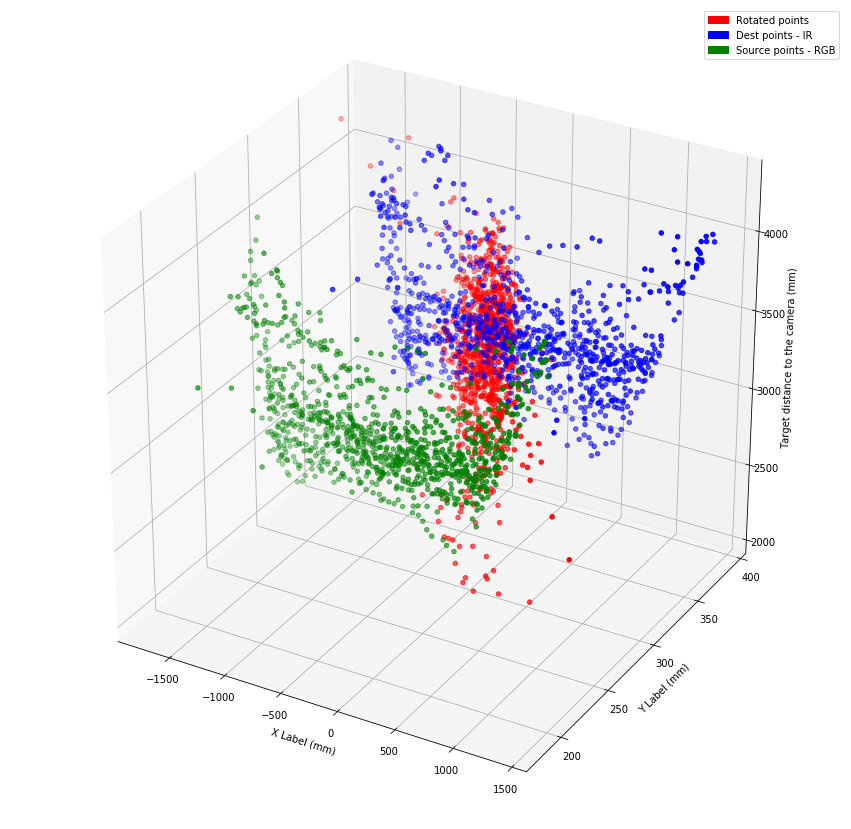

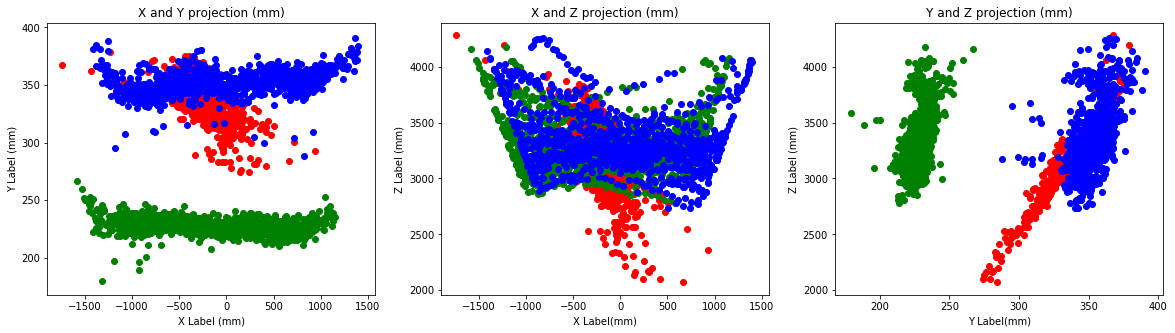

In [190]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

red_patch = mpatches.Patch(color='red', label='Rotated points')
green_patch = mpatches.Patch(color='green', label='Source points - RGB')
blue_patch = mpatches.Patch(color='blue', label='Dest points - IR')
plt.legend(handles=[red_patch,blue_patch,green_patch])

ax2.set_xlabel('X Label (mm)')
ax2.set_ylabel('Y Label (mm)')
ax2.set_zlabel('Target distance to the camera (mm)')

ax2.scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,1],transformed_points_rgbt[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b')

fig_final, axs_f = plt.subplots(1,3,figsize=(20,5))

axs_f[0].scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,1], c='r')
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='g')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b')
axs_f[0].set_xlabel('X Label (mm)')
axs_f[0].set_ylabel('Y Label (mm)')
axs_f[0].set_title('X and Y projection (mm)')

axs_f[1].scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,2], c='r')
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='g')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].set_xlabel('X Label(mm)')
axs_f[1].set_ylabel('Z Label (mm)')
axs_f[1].set_title('X and Z projection (mm)')

axs_f[2].scatter(transformed_points_rgbt[:,1],transformed_points_rgbt[:,2], c='r')
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='g')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].set_xlabel('Y Label(mm)')
axs_f[2].set_ylabel('Z Label (mm)')
axs_f[2].set_title('Y and Z projection (mm)')

plt.show()

<h1>Calculate transformations (from Thermal to RGB) </h1> 

In [191]:
desvio_trgb,inliers_trgb,n_trgb,transformed_points_trgb,Rt_trgb=min_error(objectPoints2,objectPoints1,c)

1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
1576.0309098009775
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
1225.9445800909018
1225.9445800909018
606.1454696735

606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.145469

606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
606.1454696735171
Iteration: 31 
Number of inliers: 5 
Total of points in each sensor: 974 
Desvio:  606.1454696735171 

[[ 3.28656099e-01 -3.70686940e-01 -9.85521748e-01  3.21505383e+03]
 [-1.45891153e-02  2.16374827e+00 -4.78650189e-02 -3.674

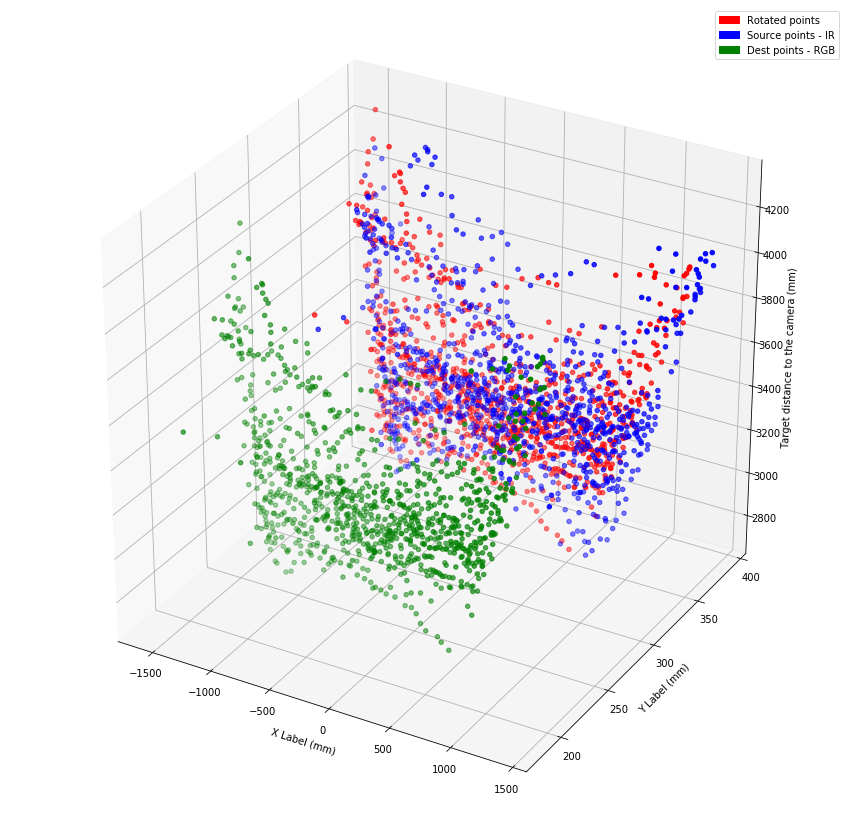

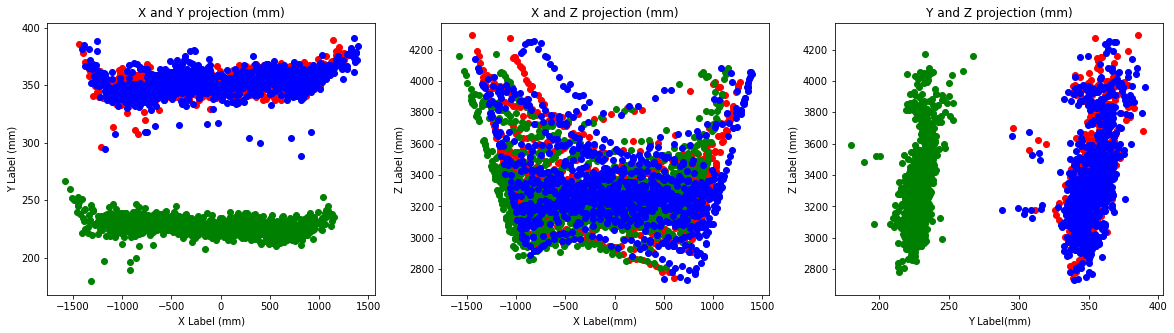

In [209]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

red_patch = mpatches.Patch(color='red', label='Rotated points')
green_patch = mpatches.Patch(color='green', label='Dest points - RGB')
blue_patch = mpatches.Patch(color='blue', label='Source points - IR')
plt.legend(handles=[red_patch,blue_patch,green_patch])

ax2.set_xlabel('X Label (mm)')
ax2.set_ylabel('Y Label (mm)')
ax2.set_zlabel('Target distance to the camera (mm)')

ax2.scatter(new_points[:,0],new_points[:,1],new_points[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b')

fig_final, axs_f = plt.subplots(1,3,figsize=(20,5))

axs_f[0].scatter(new_points[:,0],new_points[:,1], c='r')
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='g')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b')
axs_f[0].set_xlabel('X Label (mm)')
axs_f[0].set_ylabel('Y Label (mm)')
axs_f[0].set_title('X and Y projection (mm)')

axs_f[1].scatter(new_points[:,0],new_points[:,2], c='r')
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='g')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].set_xlabel('X Label(mm)')
axs_f[1].set_ylabel('Z Label (mm)')
axs_f[1].set_title('X and Z projection (mm)')

axs_f[2].scatter(new_points[:,1],new_points[:,2], c='r')
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='g')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].set_xlabel('Y Label(mm)')
axs_f[2].set_ylabel('Z Label (mm)')
axs_f[2].set_title('Y and Z projection (mm)')

plt.show()

In [213]:
T, distances, i=icp(objectPoints1,objectPoints2)
new_points=transformation(objectPoints1,T)
rmse=mean_squared_error(new_points,objectPoints2,squared=False)

587.4057119560028